In [2]:
import pandas as pd
import numpy as np
import librosa

def load_audio(audio_path):
    return librosa.load(audio_path, sr=None)

df = pd.read_csv('Path_DF.csv')
pump_train = df[(df.Dataset == 'train') & (df.Machine_Type == 'pump')]

pump_train.head()

,Path,Machine_Type,Dataset,Status,Machine_ID,Sample_ID,nb_echantillon,freq_echantillonnage,audio
22088,Data/pump/train/normal_id_00_00000692.wav,pump,train,normal,0,692,160000,16000,[ 0.00042725 0.0118103 0.00973511 ... -0.01...
22089,Data/pump/train/normal_id_06_00000093.wav,pump,train,normal,6,93,160000,16000,[-0.00543213 -0.00775146 -0.00292969 ... -0.00...
22090,Data/pump/train/normal_id_00_00000686.wav,pump,train,normal,0,686,160000,16000,[ 0.00271606 0.00646973 0.00375366 ... 0.00...
22091,Data/pump/train/normal_id_06_00000087.wav,pump,train,normal,6,87,160000,16000,[0.00985718 0.00939941 0.00210571 ... 0.008392...
22092,Data/pump/train/normal_id_02_00000058.wav,pump,train,normal,2,58,160000,16000,[-0.02572632 -0.02514648 -0.01828003 ... 0.01...


## On prépare les données pour pouvoir entrainer le modèle DenseAE

In [3]:
from FonctionsDense import * 

from time import time
t0 = time()

pump_train_stream = dataset_stream(pump_train)

t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

Réalisé en 245.336 secondes


In [4]:
np.save('pump_train_dense.npy', pump_train_stream)

# pump_train_stream = np.load('pump_train_dense.npy') si on veut le charger

## On entraine un modèle DenseAE avec la dataset nouvellement créée

In [6]:
model_dense_pump = model_denseAE()

# On compile 
model_dense_pump.compile(optimizer='adam', loss="mse")

In [7]:
import os
cwd = os.getcwd()
filepath = cwd + '/pump_DenseAE.hdf5'

filepath

'/Users/romeo/Formation DataScientist/projet pynomaly/pump_DenseAE'

In [10]:
from tensorflow.keras import callbacks

# Callback pour arrêter l'entrainement et récupérer le meilleur modèle si la métrique ne diminue plus pendant 10 epochs
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

import os
cwd = os.getcwd()
filepath = cwd

# Callback pour sauvegarder le meilleur modèle
checkpoint = callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_loss', save_best_only = True, 
                                       save_weights_only = False, mode = 'min', save_freq = 'epoch')

t0 = time()

# On entraine le modèle sur pump_train. 
model_dense_pump.fit(pump_train_stream, pump_train_stream, batch_size = 512, epochs = 100, callbacks=[checkpoint, early_stopping], validation_split = 0.3)

t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

Epoch 1/100
2436/2436 [==============================] - 295s 120ms/step - loss: 204.6658 - val_loss: 13.3427
INFO:tensorflow:Assets written to: /Users/romeo/Formation DataScientist/projet pynomaly/assets
Epoch 2/100
2436/2436 [==============================] - 258s 106ms/step - loss: 12.3322 - val_loss: 12.1028
INFO:tensorflow:Assets written to: /Users/romeo/Formation DataScientist/projet pynomaly/assets
Epoch 3/100
2436/2436 [==============================] - 180s 74ms/step - loss: 11.6015 - val_loss: 12.1577
Epoch 4/100
2436/2436 [==============================] - 182s 75ms/step - loss: 11.2978 - val_loss: 12.8596
Epoch 5/100
2436/2436 [==============================] - 176s 72ms/step - loss: 11.0785 - val_loss: 12.0194
INFO:tensorflow:Assets written to: /Users/romeo/Formation DataScientist/projet pynomaly/assets
Epoch 6/100
2436/2436 [==============================] - 181s 74ms/step - loss: 10.9388 - val_loss: 12.0337
Epoch 7/100
2436/2436 [==============================] - 183s 75

### On crée la dataset d'évaluation

In [11]:
pump_test = df[(df.Dataset == 'test') & (df.Machine_Type == 'pump')]

t0 = time()

pump_test_stream = dataset_stream(pump_test)
np.save('pump_test_dense.npy', pump_test_stream)

t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

Réalisé en 66.406 secondes


In [13]:
# Pour déterminer le seuil à partir duquel on peut dire qu'une prise de son est anormale

pred_pump_train = model_dense_pump.predict(pump_train_stream)

In [15]:
error_pump_train = errors(pump_train_stream, pred_pump_train, len(pump_train))

#print(error_valve)
print('Moyenne des erreurs :', np.mean(error_pump_train))
print('Ecart-type des erreurs :', np.std(error_pump_train))

# Donc un seuil un peu plus grand que 11.9 est bien pour trouver les prises de sons anormales détectées par le modèle

Moyenne des erreurs : 10.681114802874584
Ecart-type des erreurs : 1.21653399848138


In [17]:
pred_pump_test = model_dense_pump.predict(pump_test_stream)

error_pump_test = errors(pump_test_stream, pred_pump_test, len(pump_test))


In [18]:
y_true = pump_test['Status'].replace(['normal', 'anomaly'], [0,1])

y_true.value_counts()

1    456
0    400
Name: Status, dtype: int64

In [32]:
seuil = 11.8 # valeur à déterminer selon les erreurs 

y_pred = np.where(error_pump_test[:] > seuil, 1, 0)

pd.crosstab(y_true, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,293,107
1,156,300


In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.65      0.73      0.69       400
           1       0.74      0.66      0.70       456

    accuracy                           0.69       856
   macro avg       0.69      0.70      0.69       856
weighted avg       0.70      0.69      0.69       856



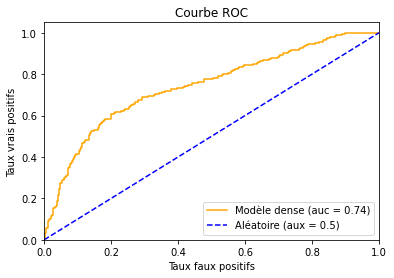

In [21]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, seuils = roc_curve(y_true, error_pump_test, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'orange', label = 'Modèle dense (auc = %0.2f)' % roc_auc)
plt.title('Courbe ROC')
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.xlim(0,1)
plt.ylim(0,1.05)

plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (aux = 0.5)')

plt.legend(loc = 'lower right')
plt.show();

In [23]:
auc = roc_auc_score(y_true, error_pump_test)
p_auc = roc_auc_score(y_true, error_pump_test, max_fpr=0.1)

print("AUC : {}".format(auc))
print("pAUC : {}".format(p_auc))

AUC : 0.7424122807017544
pAUC : 0.5995787165281625


## Affinons notre analyse selon le Machine_ID

In [35]:
#valve_train.Machine_ID.value_counts()
pump_train.Machine_ID.unique()

array([0, 6, 2, 4])

### Premier Machine_ID : 0

In [42]:
error_pump_train_0 = error_pump_train[pump_train.Machine_ID == 0]

print('Moyenne des erreurs :', np.mean(error_pump_train_0))
print('Ecart-type des erreurs :', np.std(error_pump_train_0))

seuil = 12.2 # valeur à déterminer selon les erreurs 

Moyenne des erreurs : 11.409545268770056
Ecart-type des erreurs : 0.9729764651023486


In [43]:
error_pump_test_0 = error_pump_test[pump_test.Machine_ID == 0]

y_true_0 = y_true[pump_test.Machine_ID == 0]
y_pred_0 = np.where(error_pump_test_0[:] > seuil, 1, 0)

print(classification_report(y_true_0, y_pred_0))
pd.crosstab(y_true_0, y_pred_0, rownames=['Classe réelle'], colnames=['Classe prédite'])

              precision    recall  f1-score   support

           0       0.64      0.63      0.64       100
           1       0.74      0.76      0.75       143

    accuracy                           0.70       243
   macro avg       0.69      0.69      0.69       243
weighted avg       0.70      0.70      0.70       243



Classe prédite,0,1
Classe réelle,,
0,63,37
1,35,108


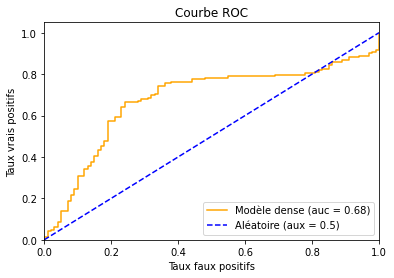

In [45]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, seuils = roc_curve(y_true_0, error_pump_test_0, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'orange', label = 'Modèle dense (auc = %0.2f)' % roc_auc)
plt.title('Courbe ROC')
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.xlim(0,1)
plt.ylim(0,1.05)

plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (aux = 0.5)')

plt.legend(loc = 'lower right')
plt.show();

In [46]:
auc = roc_auc_score(y_true_0, error_pump_test_0)
p_auc = roc_auc_score(y_true_0, error_pump_test_0, max_fpr=0.1)

print("AUC : {}".format(auc))
print("pAUC : {}".format(p_auc))

AUC : 0.6767832167832168
pAUC : 0.5358851674641149


### Deuxième Machine_ID : 2 

In [55]:
error_pump_train_2 = error_pump_train[pump_train.Machine_ID == 2]

print('Moyenne des erreurs :', np.mean(error_pump_train_2))
print('Ecart-type des erreurs :', np.std(error_pump_train_2))

seuil = 11.5 # valeur à déterminer selon les erreurs 

Moyenne des erreurs : 10.918595489128053
Ecart-type des erreurs : 0.9378396377581606


In [56]:
error_pump_test_2 = error_pump_test[pump_test.Machine_ID == 2]

y_true_2 = y_true[pump_test.Machine_ID == 2]
y_pred_2 = np.where(error_pump_test_2[:] > seuil, 1, 0)

print(classification_report(y_true_2, y_pred_2))
pd.crosstab(y_true_2, y_pred_2, rownames=['Classe réelle'], colnames=['Classe prédite'])

              precision    recall  f1-score   support

           0       0.60      0.75      0.66       100
           1       0.71      0.54      0.61       111

    accuracy                           0.64       211
   macro avg       0.65      0.65      0.64       211
weighted avg       0.65      0.64      0.64       211



Classe prédite,0,1
Classe réelle,,
0,75,25
1,51,60


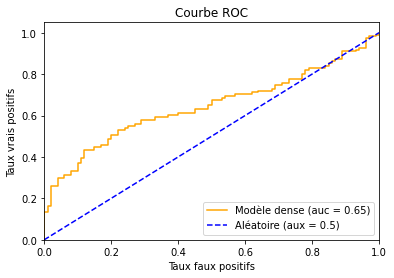

In [58]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, seuils = roc_curve(y_true_2, error_pump_test_2, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'orange', label = 'Modèle dense (auc = %0.2f)' % roc_auc)
plt.title('Courbe ROC')
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.xlim(0,1)
plt.ylim(0,1.05)

plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (aux = 0.5)')

plt.legend(loc = 'lower right')
plt.show();

In [59]:
auc = roc_auc_score(y_true_2, error_pump_test_2)
p_auc = roc_auc_score(y_true_2, error_pump_test_2, max_fpr=0.1)

print("AUC : {}".format(auc))
print("pAUC : {}".format(p_auc))

AUC : 0.6450450450450451
pAUC : 0.6164058795637744


### Troisième Machine_ID : 4

In [66]:
error_pump_train_4 = error_pump_train[pump_train.Machine_ID == 4]

print('Moyenne des erreurs :', np.mean(error_pump_train_4))
print('Ecart-type des erreurs :', np.std(error_pump_train_4))

seuil = 11.1 # valeur à déterminer selon les erreurs 

Moyenne des erreurs : 9.956731484228836
Ecart-type des erreurs : 1.2479719463965742


In [67]:
error_pump_test_4 = error_pump_test[pump_test.Machine_ID == 4]

y_true_4 = y_true[pump_test.Machine_ID == 4]
y_pred_4 = np.where(error_pump_test_4[:] > seuil, 1, 0)

print(classification_report(y_true_4, y_pred_4))
pd.crosstab(y_true_4, y_pred_4, rownames=['Classe réelle'], colnames=['Classe prédite'])

              precision    recall  f1-score   support

           0       0.93      0.63      0.75       100
           1       0.72      0.95      0.82       100

    accuracy                           0.79       200
   macro avg       0.82      0.79      0.78       200
weighted avg       0.82      0.79      0.78       200



Classe prédite,0,1
Classe réelle,,
0,63,37
1,5,95


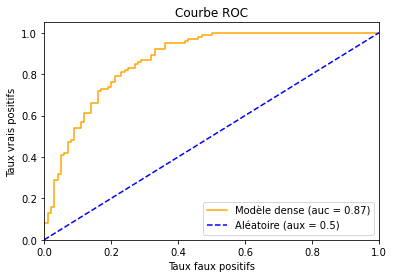

In [69]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, seuils = roc_curve(y_true_4, error_pump_test_4, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'orange', label = 'Modèle dense (auc = %0.2f)' % roc_auc)
plt.title('Courbe ROC')
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.xlim(0,1)
plt.ylim(0,1.05)

plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (aux = 0.5)')

plt.legend(loc = 'lower right')
plt.show();

In [70]:
auc = roc_auc_score(y_true_4, error_pump_test_4)
p_auc = roc_auc_score(y_true_4, error_pump_test_4, max_fpr=0.1)

print("AUC : {}".format(auc))
print("pAUC : {}".format(p_auc))

AUC : 0.8699
pAUC : 0.6473684210526316


### Quatrième Machine_ID : 6

In [90]:
error_pump_train_6 = error_pump_train[pump_train.Machine_ID == 6]

print('Moyenne des erreurs :', np.mean(error_pump_train_6))
print('Ecart-type des erreurs :', np.std(error_pump_train_6))

seuil = 10.6 # valeur à déterminer selon les erreurs 

Moyenne des erreurs : 10.212312168968648
Ecart-type des erreurs : 1.1838212586763543


In [91]:
error_pump_test_6 = error_pump_test[pump_test.Machine_ID == 6]

y_true_6 = y_true[pump_test.Machine_ID == 6]
y_pred_6 = np.where(error_pump_test_6[:] > seuil, 1, 0)

print(classification_report(y_true_6, y_pred_6))
pd.crosstab(y_true_6, y_pred_6, rownames=['Classe réelle'], colnames=['Classe prédite'])

              precision    recall  f1-score   support

           0       0.76      0.59      0.66       100
           1       0.67      0.81      0.73       102

    accuracy                           0.70       202
   macro avg       0.71      0.70      0.70       202
weighted avg       0.71      0.70      0.70       202



Classe prédite,0,1
Classe réelle,,
0,59,41
1,19,83


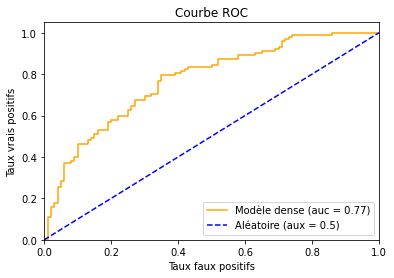

In [82]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, seuils = roc_curve(y_true_6, error_pump_test_6, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'orange', label = 'Modèle dense (auc = %0.2f)' % roc_auc)
plt.title('Courbe ROC')
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.xlim(0,1)
plt.ylim(0,1.05)

plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (aux = 0.5)')

plt.legend(loc = 'lower right')
plt.show();

In [83]:
auc = roc_auc_score(y_true_6, error_pump_test_6)
p_auc = roc_auc_score(y_true_6, error_pump_test_6, max_fpr=0.1)

print("AUC : {}".format(auc))
print("pAUC : {}".format(p_auc))

AUC : 0.7708823529411765
pAUC : 0.6057791537667698


Moyenne des erreurs : 10.367800012137605
Ecart-type des erreurs : 1.1298256344127315
